# Imports

In [89]:
#!pip install -U scikit-learn

In [90]:
from Transformation import Transformation
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [91]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [92]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [93]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [94]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([0.2, 0.2, 0.2]).reshape(1, -1)  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))                               #list of "output_dimension" for each "list_node" element
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):       # for each node and its adjacency nodes
            neigh_nodes = np.array(list(dict_neigh.keys()))                                             # array of adjacency nodes
            diff = np.subtract(current_node, neigh_nodes)                                               # Compute the differences between current_node and all neighbor nodes   (x_i - x_j)
            neigh_distances = np.linalg.norm(self.W_theta * diff, axis=1)                               # Compute the norm for each vector difference  ||W_theta * (x_i - x_j)||
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                   # Add (W_phi * ||W_theta * (x_i - x_j)||) to the inclusion score list

        if len(previous_inclusion_score)==0:                            # return if no previous inclusion score
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        if list_inc_score.shape[1]!=1:                                  # If inclusion score is not vector
            list_inc_score = np.mean(list_inc_score, axis=1)            # Mean the matrix for each node

        # array of array to array
        if len(list_inc_score.shape)==2:                 
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [95]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[1.08564568 1.08627732 1.08564568 ... 1.01069957 1.46711278 1.01069957]
[1.16957922 1.17025969 1.16957922 ... 1.08883887 1.58053834 1.08883887]
[0.71474079 0.71484973 0.71474079 ... 0.70163855 0.77578427 0.70163855]
(5999,)


### Multinomial Sampling

In [96]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 1]


In [97]:
target_number_point = min(len(graph._node), 48)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.0, -0.33300498, 98.79369), (75.0, 7.8332825, 94.00995), (75.0, 4.4479885, 2.593115), (75.72985, 7.138877, 95.12641), (75.0, 1.6554987, 98.642876), (89.08757, 5.7970243, 87.47219), (92.26922, 2.3044074, 2.8949585), (75.04185, 2.6241417, 3.401829), (76.20523, 4.4479885, 3.7368364), (92.148476, 2.7826276, 29.6), (82.89438, -8.78582, 1.2349607), (77.66334, -7.8332825, -8.7300205), (75.0, -4.7321377, 97.41936), (75.023026, 0.66553295, 81.21025), (75.21826, 1.9813722, 3.7415173), (79.52085, -8.78582, -3.1615038), (75.02465, 0.66553295, 81.20524), (83.95425, 8.798424, 3.330728), (75.20642, 1.9813722, 3.708094), (85.27754, 8.672658, 3.261377), (77.78412, 7.5075808, 94.29826), (76.39973, 7.5075808, 94.51753), (75.175606, 1.9813722, 3.6577988), (89.94287, 6.2811418, 3.0168772), (75.0, -8.535009, 92.14327), (90.083786, -5.7970243, 84.40616), (77.77186, 7.9794145, -0.46828538), (39.0, -8.8, 90.0), (39.0, -0.49935842, 81.21418), (77.51886, 6.1633806, 42.5), (80.703445, 8.237194, 3.8), (82.3634

# KNN

In [98]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.0, -0.33300498, 98.79369], [75.0, 7.8332825, 94.00995], [75.0, 4.4479885, 2.593115], [75.72985, 7.138877, 95.12641], [75.0, 1.6554987, 98.642876], [89.08757, 5.7970243, 87.47219], [92.26922, 2.3044074, 2.8949585], [75.04185, 2.6241417, 3.401829], [76.20523, 4.4479885, 3.7368364], [92.148476, 2.7826276, 29.6], [82.89438, -8.78582, 1.2349607], [77.66334, -7.8332825, -8.7300205], [75.0, -4.7321377, 97.41936], [75.023026, 0.66553295, 81.21025], [75.21826, 1.9813722, 3.7415173], [79.52085, -8.78582, -3.1615038], [75.02465, 0.66553295, 81.20524], [83.95425, 8.798424, 3.330728], [75.20642, 1.9813722, 3.708094], [85.27754, 8.672658, 3.261377], [77.78412, 7.5075808, 94.29826], [76.39973, 7.5075808, 94.51753], [75.175606, 1.9813722, 3.6577988], [89.94287, 6.2811418, 3.0168772], [75.0, -8.535009, 92.14327], [90.083786, -5.7970243, 84.40616], [77.77186, 7.9794145, -0.46828538], [39.0, -8.8, 90.0], [39.0, -0.49935842, 81.21418], [77.51886, 6.1633806, 42.5], [80.703445, 8.237194, 3.8], [82.3634

In [99]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [100]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 48
Number of edges: 570


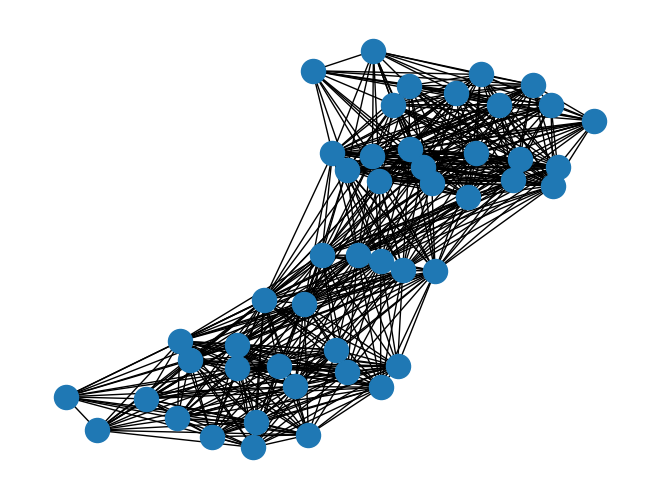

In [101]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [102]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(48, 64)


In [103]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

#construction du fi
# fi = np.random.randint(100, size=(50, 1))
# for n in range(np.size(inclusion_score,0)):
#     fi[i] = np.mean(inclusion_score[i][:])
    
# fj = np.random.randint(100, size=(50, 1))
# for m in range(np.size(inclusion_score,0)):
#     fj[i] = np.mean(inclusion_score[i][:])

f = np.random.rand(target_number_point)


# f1i = np.mean(inclusion_score)
# f1j = np.mean(inclusion_score)

S = np.random.rand(target_number_point, target_number_point)
wq = np.random.rand(64)
wk = np.random.rand(64)

In [104]:
for i in range(np.size(f,0)):
    for j in range(np.size(f, 0)): 
        f[i] = np.mean(inclusion_score[i][:])
        #print("f[",i,"] : " , f[i])
        f[j] = np.mean(inclusion_score[j][:])
        #print("f[",j,"] : " , f[j])
        wq_fi = wq*f[i].transpose()
        #print("wq_fi : " , wq_fi.transpose())
        wk_fj = wk*f[j]
        #print("wk_fj : " , wk_fj)
        wq_wk = np.matmul(wk_fj, wq_fi)
        #print("wq_wk : " , wq_wk)
        sum_wq_wk = 0
        for k in range(np.size(f, 0)):
            f[k] = np.mean(inclusion_score[k][:])
            #print("f[",k,"]",f[k])
            
            #print("wk*f[",k,"] * wq_fi = ",np.matmul(wk*f[k],wq_fi))
            #print("exp : " ,np.exp(np.matmul(wk*f[k],wq_fi))) #ça marche mais faut réduire les valeurs c'est trop grand
            sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
            #print("somme : " , sum_wq_wk)
        print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
        print("somme : ", sum_wq_wk)
        S[i][j] = np.exp(wq_wk)/sum_wq_wk
        print("S[",i,"][",j,"] :" , S[i][j])


exp(wq_wk) : 4.585303311428542e+100
somme :  3.1021450025881147e+198
S[ 0 ][ 0 ] : 1.4781073443062882e-98
exp(wq_wk) : 4.370595505595816e+100
somme :  3.1021450025881147e+198
S[ 0 ][ 1 ] : 1.4088946525547436e-98
exp(wq_wk) : 5.785311635465359e+99
somme :  3.1021450025881147e+198
S[ 0 ][ 2 ] : 1.86493914070383e-99
exp(wq_wk) : 1.1335606984667538e+44
somme :  3.1021450025881147e+198
S[ 0 ][ 3 ] : 3.6541189967620015e-155
exp(wq_wk) : 2.6413375479657654e+101
somme :  3.1021450025881147e+198
S[ 0 ][ 4 ] : 8.514552175227469e-98
exp(wq_wk) : 1.3803929405465862e+103
somme :  3.1021450025881147e+198
S[ 0 ][ 5 ] : 4.449801474124925e-96
exp(wq_wk) : 8.693095763958412e+166
somme :  3.1021450025881147e+198
S[ 0 ][ 6 ] : 2.8022854369172867e-32
exp(wq_wk) : 8.940849464327563e+167
somme :  3.1021450025881147e+198
S[ 0 ][ 7 ] : 2.882150723730911e-31
exp(wq_wk) : 5.164557425163947e+166
somme :  3.1021450025881147e+198
S[ 0 ][ 8 ] : 1.6648343068603062e-32
exp(wq_wk) : 2.5478052520791317e+165
somme :  3.1

C:\Users\Arthur\AppData\Local\Temp\ipykernel_14556\421861201.py:20: RuntimeWarning: overflow encountered in exp
  sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14556\421861201.py:22: RuntimeWarning: overflow encountered in exp
  print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14556\421861201.py:24: RuntimeWarning: overflow encountered in exp
  S[i][j] = np.exp(wq_wk)/sum_wq_wk
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14556\421861201.py:24: RuntimeWarning: invalid value encountered in double_scalars
  S[i][j] = np.exp(wq_wk)/sum_wq_wk


exp(wq_wk) : 1.0458407313548359e+272
somme :  inf
S[ 7 ][ 10 ] : 0.0
exp(wq_wk) : 6.873192316330467e+244
somme :  inf
S[ 7 ][ 11 ] : 0.0
exp(wq_wk) : 5.000214615001432e+235
somme :  inf
S[ 7 ][ 12 ] : 0.0
exp(wq_wk) : 6.002740427180522e+232
somme :  inf
S[ 7 ][ 13 ] : 0.0
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 14 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 15 ] : nan
exp(wq_wk) : 1.890353269595024e+243
somme :  inf
S[ 7 ][ 16 ] : 0.0
exp(wq_wk) : 4.0010920074604883e+155
somme :  inf
S[ 7 ][ 17 ] : 0.0
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 18 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 19 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 20 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 21 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 22 ] : nan
exp(wq_wk) : 1.3487911532523978e+169
somme :  inf
S[ 7 ][ 23 ] : 0.0
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 24 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 25 ] : nan
exp(wq_wk) : inf
somme :  inf
S[ 7 ][ 26 ] : nan
exp(wq_wk) : 2.547458411989904e

### Sparse Attention

# Face Candidates

#### Inputs

In [105]:
adjacency = nx.adjacency_matrix(extended_graph)
# S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 32)	1
  (0, 44)	1
  (0, 45)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  :	:
  (46, 22)	1
  (46, 23)	1
  (46, 24)	1
  (46, 25)	1
  (46, 28)	1
  (46, 30)	1
  (46, 31)	1
  (46, 37)	1
  (46, 43)	1
  (46, 47)	1
  (47, 17)	1
  (47, 18)	1
  (47, 19)	1
  (47, 20)	1
  (47, 21)	1
  (47, 22)	1
  (47, 23)	1
  (47, 24)	1
  (47, 25)	1
  (47, 28)	1
  (47, 30)	1
  (47, 31)	1
  (47, 37)	1
  (47, 43)	1
  (47, 46)	1
[[1.47810734e-098 1.40889465e-098 1.86493914e-099 ... 1.99887627e-094
  3.12077287e-083 2.83322063e-079]
 [1.54826748e-098 1.47578417e-098 1.95429760e-099 ... 2.08963862e-094
  3.24512504e-083 2.94056464e-079]
 [1.09413419e-097 1.04334792e-097 1.40623832e-098 ... 1.35910945e-093
  1.68561309e-082 1.41067089e-078]
 ...
 [1.49597337e-102 1.42312046e-102 1.73374992e-103 ... 2.98910211

In [106]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[0.66996008 0.66996199 0.67004437 ... 0.66962251 0.66901352 0.66887241]
 [0.66996199 0.66996389 0.67004627 ... 0.66962442 0.66901543 0.66887433]
 [0.67004437 0.67004627 0.6701286  ... 0.66970699 0.66909836 0.66895734]
 ...
 [0.66962251 0.66962442 0.66970699 ... 0.66928416 0.66867363 0.66853213]
 [0.66901352 0.66901543 0.66909836 ... 0.66867363 0.66806003 0.6679177 ]
 [0.66887241 0.66887433 0.66895734 ... 0.66853213 0.6679177  0.66777515]]
(48, 48)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [107]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (75.0, -4.7321377, 97.41936)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (80.3438, -2.3044074, 97.646545)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (75.72985, 7.138877, 95.12641)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (76.39973, 7.5075808, 94.51753)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (77.78412, 7.5075808, 94.29826)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (75.0, 7.8332825, 94.00995)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (84.017044, -4.1574683, 95.08502)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (75.0, -8.535009, 92.14327)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (86.73878, 0.99710757, 94.237236)], [(75.0, -0.33300498, 98.79369), (75.0, 1.6554987, 98.642876), (77.24825, -7.6759295, 85.094086)], [(75.0, -0.33300498, 98.79369), (75.0, 1.655

In [108]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[0.67001754 0.69517957 0.66991597 ...        nan 0.66862809        nan]


#### Calculate barycenter

In [109]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[75.0, -1.1365479628245037, 98.28530883789062], [76.78127034505208, -0.32730452219645184, 98.36104329427083], [75.2432861328125, 2.8204568227132163, 97.52099609375], [75.46657307942708, 2.9433581034342446, 97.31803385416667], [75.92803955078125, 2.9433581034342446, 97.2449442545573], [75.0, 3.0519253412882485, 97.14884440104167], [78.00568135579427, -0.9449915091196696, 97.5072021484375], [75.0, -2.404171943664551, 96.526611328125], [78.91292317708333, 0.7732004324595133, 97.22459920247395], [75.74942016601562, -2.117811838785807, 94.1768798828125], [75.56402587890625, 2.6107892990112305, 93.65517171223958], [75.41211954752605, 2.288275400797526, 93.38778686523438], [75.00767517089844, 0.6626755793889364, 92.8822733561198], [75.00821940104167, 0.6626755793889364, 92.88060506184895], [79.69585673014323, 2.3731727600097656, 94.96958414713542], [80.02792867024739, -1.4915100733439128, 93.94757080078125], [63.0, -2.492502212524414, 95.81219482421875], [63.0, 0.2743784586588542, 92.8835856

In [110]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [111]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(75.0, -1.1365479628245037, 98.28530883789062): {'index_poly': {0, 1, 161, 7, 18, 19}}, (76.78127034505208, -1.7936820983886719, 97.90292358398438): {'index_poly': {0, 1, 161, 6, 7, 40, 166, 167, 18, 23, 183}}, (76.78127034505208, -0.32730452219645184, 98.36104329427083): {'index_poly': {0, 1, 161, 6, 304, 18}}, (75.0, -2.404171943664551, 96.526611328125): {'index_poly': {0, 161, 322, 7, 40, 167, 361, 336, 18, 309, 183, 24, 349}}, (75.2432861328125, 0.6912447611490885, 97.11314900716145): {'index_poly': {0, 1, 2, 162, 163, 164, 165, 196, 210, 19, 20, 21, 22, 307}}, (76.78127034505208, -2.4565165837605796, 97.9531962076823): {'index_poly': {0, 1, 161, 6, 7, 40, 166, 167, 18, 23, 24, 183}}, (75.46657307942708, 0.8141460418701172, 96.91019694010417): {'index_poly': {0, 1, 2, 3, 19, 20, 21, 22, 162, 163, 164, 165, 38, 304, 307, 53, 196, 210, 223, 235}}, (75.0, 0.9227132797241211, 96.74099731445312): {'index_poly': {0, 2, 3, 5, 19, 20, 21, 22, 162, 163, 164, 165, 53, 67, 196, 210, 92, 223,

In [112]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 3635
Number of edges: 109479


#### calculate e norm matrix

In [113]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[1.9942149, 4.6088142, 6.50376], [1.9942149, 5.810216, 6.725308], [1.9942149, 8.355277, 6.554818], [1.9942149, 9.039888, 7.2955165], [1.9942149, 9.457007, 7.802169], [1.9942149, 9.464273, 7.7219834], [1.9942149, 10.473196, 11.302919], [1.9942149, 10.559402, 12.086823], [1.9942149, 12.662125, 12.555557], [1.9942149, 15.705173, 16.604214], [1.9942149, 16.813711, 15.96431], [1.9942149, 17.152071, 16.430393], [1.9942149, 17.611788, 17.460726], [1.9942149, 17.616795, 17.465734], [1.9942149, 19.084373, 18.449825], [1.9942149, 21.549414, 22.03962], [1.9942149, 38.01341, 38.470985], [1.9942149, 40.063286, 40.054996], [4.6088142, 5.810216, 5.8738165], [4.6088142, 8.355277, 12.112443], [4.6088142, 9.039888, 12.65664], [4.6088142, 9.457007, 12.934576], [4.6088142, 9.464273, 13.019749], [4.6088142, 10.473196, 9.332012], [4.6088142, 10.559402, 6.503761], [4.6088142, 12.662125, 13.444294], [4.6088142, 15.705173, 12.8698435], [4.6088142, 16.813711, 17.949644], [4.6088142, 17.152071, 17.971222], [4.6

#### Calculate r

In [114]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

max_diff_vectors = np.array(diff_vectors).max(axis=1)
min_diff_vectors = np.array(diff_vectors).min(axis=1)

barycenters_numpy = np.array(barycenters)

# Calculate differences once to avoid redundant computations
diff_vectors = min_diff_vectors[:, np.newaxis] - min_diff_vectors
max_diff_vectors_diff = max_diff_vectors[:, np.newaxis] - max_diff_vectors
barycenters_diff = barycenters_numpy[:, np.newaxis, :] - barycenters_numpy

# Populate the r_matrix using vectorized operations
r_matrix = np.stack([diff_vectors, max_diff_vectors_diff, barycenters_diff[:, :, 0], barycenters_diff[:, :, 1], barycenters_diff[:, :, 2]], axis=-1)

print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

(3635, 3635, 5)


#### Calculate f

In [115]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

nan
(3635,)
[nan nan nan ... nan nan nan]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_14556\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [116]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(48, 3, 3)


In [117]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [118]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(77.24825, -7.6759295, 85.094086): {'index_triangle': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41}}, (75.023026, 0.66553295, 81.21025): {'index_triangle': {0, 1, 3, 4, 40, 29}}, (75.02465, 0.66553295, 81.20524): {'index_triangle': {0, 5, 39, 12, 47, 18, 20, 28}}, (90.083786, -5.7970243, 84.40616): {'index_triangle': {1, 37, 12, 13, 14, 15, 16, 17, 26}}, (89.08757, 5.7970243, 87.47219): {'index_triangle': {2, 3, 5, 38, 8, 9, 10, 11, 27}}, (89.079704, 7.0402236, 55.4): {'index_triangle': {2, 34, 13, 23}}, (39.0, -8.8, 90.0): {'index_triangle': {4, 36, 47, 18, 25}}, (76.23637, 5.5423326, 82.72679): {'index_triangle': {6, 7, 41, 19, 22, 23, 24, 25, 26, 27, 28, 29}}, (77.51886, 6.1633806, 42.5): {'index_triangle': {6, 10, 42, 43, 45, 16, 31}}, (90.08114, 6.1633806, 42.5): {'index_triangle': {32, 7, 9, 43, 44, 46, 15}}, (92.24779, -2.464716, 55.4): {'index_triangle': {33, 8, 45, 14,

In [119]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 15
Number of edges: 65


In [120]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)